In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import jit, float64
from numba.experimental import jitclass
import quantecon as qe
from quantecon.distributions import BetaBinomial

$$ \mathbb{E} \sum_{t=0}^{\infty} \beta^t y_t $$

we need to consider the trade-off wage that given state $s$ we try to find out maximal lifetime value $v^*$
$$ v^*(w)
= \max \left\{
        \frac{w}{1 - \beta}, \, c + \beta
        \sum_{w' \in \mathbb{W}} v^*(w') q (w')
    \right\} $$
for every possible $w$ in $\mathbb{W}$

The optimal policy in general, a map from states to actions.

- Given any $w$, we can read off the corresponding best choice by picking the max on the right-hand side of value function.

- We can write the policy as follows
$$ \sigma(w) := \mathbf{1}
    \left\{
        \frac{w}{1 - \beta} \geq c + \beta \sum_{w' \in \mathbb W}
        v^*(w') q (w')
    \right\} $$
Another formation is:
$$ \sigma(w):=\mathbf{1}\{w\ge \bar{w}\} $$
where $$ \bar{w}:=(1-\beta)\left\{c+\beta \sum_{w'}v^*(w')q(w')\right\} $$

In [2]:
n, a, b = 50, 200, 100                        # default parameters
q_default = BetaBinomial(n, a, b).pdf()       # default choice of q

In [3]:
w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n+1)

Here’s a plot of the probabilities of different wage outcomes:

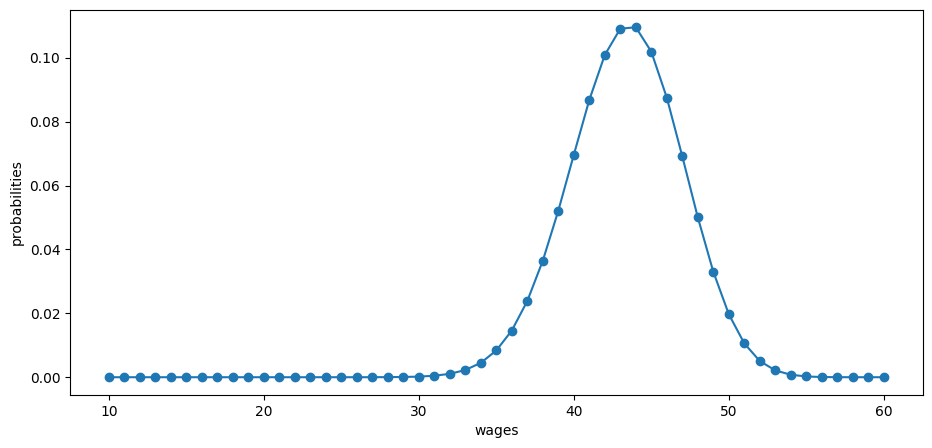

In [4]:
fig, ax = plt.subplots()
ax.plot(w_default, q_default, '-o', label='$q(w(i))$')
ax.set_xlabel('wages')
ax.set_ylabel('probabilities')

plt.show()

We are going to use Numba to accelerate our code.
- `jitclass`

In [6]:
mccall_data = [
    ('c', float64),      # unemployment compensation
    ('β', float64),      # discount factor
    ('w', float64[:]),   # array of wage values, w[i] = wage at state i
    ('q', float64[:])    # array of probabilities
]

In [7]:
@jitclass(mccall_data)
class McCallModel:

    def __init__(self, c=25, β=0.99, w=w_default, q=q_default):

        self.c, self.β = c, β
        self.w, self.q = w_default, q_default

    def state_action_values(self, i, v):
        """
        The values of state-action pairs.
        """
        # Simplify names
        c, β, w, q = self.c, self.β, self.w, self.q
        # Evaluate value for each state-action pair
        # Consider action = accept or reject the current offer
        accept = w[i] / (1 - β)
        reject = c + β * np.sum(v * q)

        return np.array([accept, reject])

In [8]:
def plot_value_function_seq(mcm, ax, num_plots=6):
    """
    Plot a sequence of value functions.

        * mcm is an instance of McCallModel
        * ax is an axes object that implements a plot method.

    """

    n = len(mcm.w)
    v = mcm.w / (1 - mcm.β)
    v_next = np.empty_like(v)
    for i in range(num_plots):
        ax.plot(mcm.w, v, '-', alpha=0.4, label=f"iterate {i}")
        # Update guess
        for j in range(n):
            v_next[j] = np.max(mcm.state_action_values(j, v))
        v[:] = v_next  # copy contents into v

    ax.legend(loc='lower right')

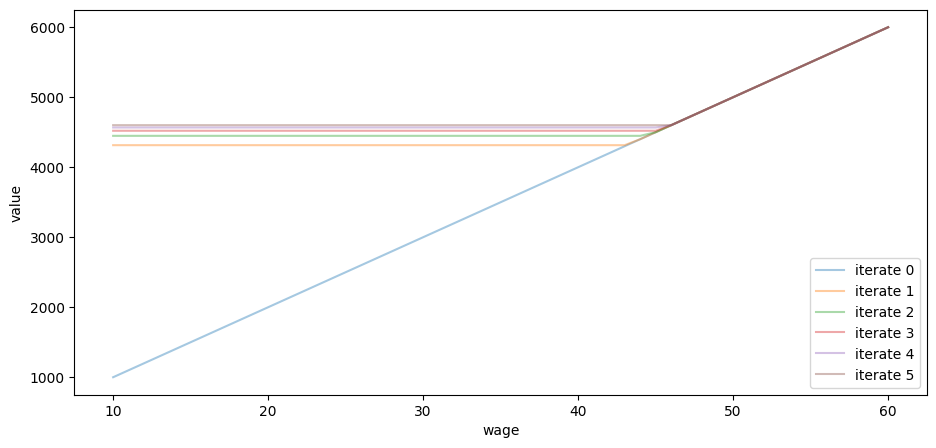

In [9]:
mcm = McCallModel()

fig, ax = plt.subplots()
ax.set_xlabel('wage')
ax.set_ylabel('value')
plot_value_function_seq(mcm, ax)
plt.show()

In [10]:
@jit(nopython=True)
def compute_reservation_wage(mcm,
                             max_iter=500,
                             tol=1e-6):

    # Simplify names
    c, β, w, q = mcm.c, mcm.β, mcm.w, mcm.q

    # == First compute the value function == #

    n = len(w)
    v = w / (1 - β)          # initial guess
    v_next = np.empty_like(v)
    j = 0
    error = tol + 1
    while j < max_iter and error > tol:

        for j in range(n):
            v_next[j] = np.max(mcm.state_action_values(j, v))

        error = np.max(np.abs(v_next - v))
        j += 1

        v[:] = v_next  # copy contents into v

    # == Now compute the reservation wage == #

    return (1 - β) * (c + β * np.sum(v * q))